### Redução de Dimensionalidade

Quando o nosso problema é descrito por muitas features isso acarreta problemas no tempo de treinamento e mesmo na viabilidade do modelo final. Não raro é possível representar um problema com menos features sem perda de informação e até com ganho no desempenho do modelo. Isso se dá porque algumas técnicas de redução de dimensionalidade podem acabar reduzindo o ruído nos dados e facilitando que o modelo seja bom.

Estudaremos as principais abordagens de redução de dimensionalidade (projeção e manifold) e as principais técnicas (PCA, Kernel PCA e LLE).



#### Projeção

Na prática, um problema representado em um espaço multidimensional não possui os pontos que representam os dados espalhados uniformemente nas dimensões. Algumas poucas dimensões concentram as maiores variâncias e outras possuem uma variância bem menos. Assim, é possível representar o problema nas dimensões mais informativas sem muita perda informacional.


#### Manifold

Um manifold é um modelo que representa um objeto que localmente parece ser de uma dimensão (ex: 2D) mas que é na verdade uma forma retorcida em uma dimensão maior (3D). O aprendizado manifold tenta modelar como é esse objeto (3D, no nosso exemplo) para que, aí sim, sua projeção em menor dimensão possa ser útil ao problema (2D no nosso exemplo)..

In [24]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plot

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

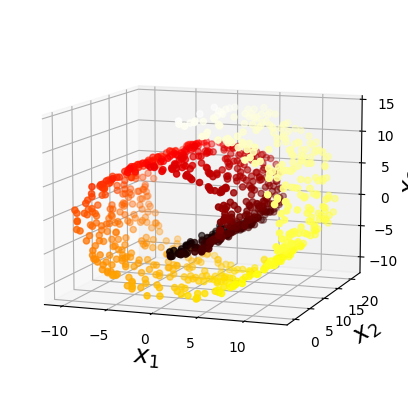

In [25]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

Exemplo de Manifold do dataset swissroll. Pra separar esse troço precisá-mos projetá-lo.

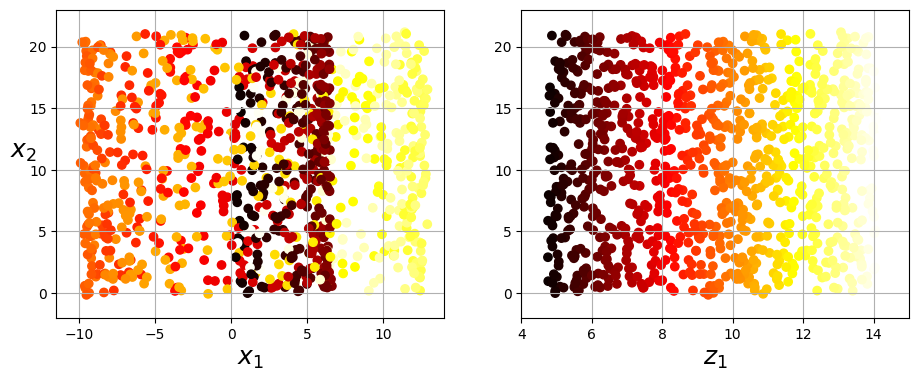

In [26]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

Decompondo é plenamente possível agora encontrar fronteiras de decisão:

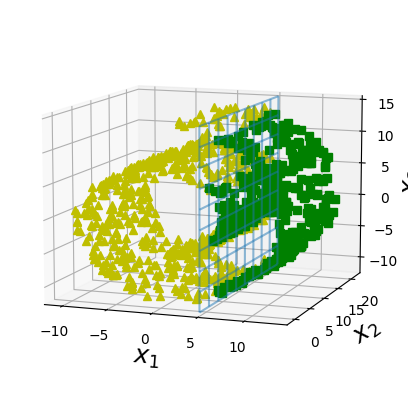

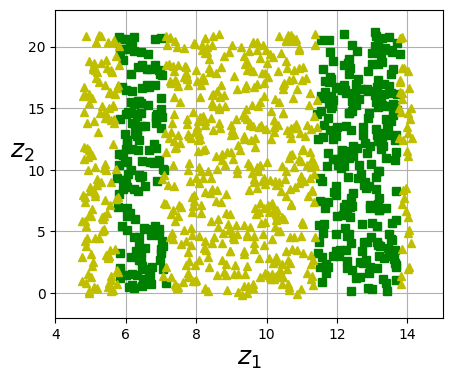

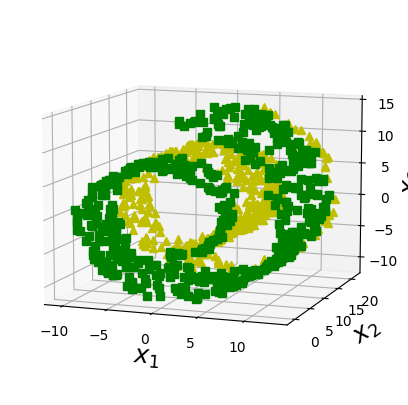

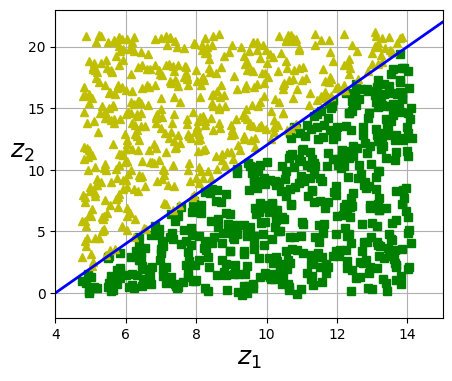

In [28]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)


plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)


plt.show()

#### PCA - Análise de Componentes Principais

É um algoritmo muito popular de redução de dimensionalidade. Ele identifica o hiperplano mais próximo e depois projeta os dados nele, de modo a preservar a variância.

Pra ver como funciona vamos construir um dataset 3D.

In [2]:
import numpy as np 

np.random.seed(2023)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

Criados os dados vamos encontrar os componentes principais.

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered) # a decomposição em valores singulados ajuda a char os componentes principais
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

projetando as dimensões

In [4]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [5]:

X2D_using_svd = X2D

### PCA com Sklearn
Claro que esses cálculos não precisam ser feitos assim o tempo todo. O Scikit-learn cria modos simplificados para isso. Vejamos:

In [6]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [7]:
X2D[:5]

array([[-0.84612357, -0.19770047],
       [ 1.49410581,  0.32925302],
       [ 0.52146859, -0.39814913],
       [-0.72737543,  0.41551991],
       [-0.86477582,  0.43044362]])

In [8]:
X2D_using_svd[:5]

array([[-0.84612357, -0.19770047],
       [ 1.49410581,  0.32925302],
       [ 0.52146859, -0.39814913],
       [-0.72737543,  0.41551991],
       [-0.86477582,  0.43044362]])

In [10]:
np.allclose(X2D, X2D_using_svd)

True

Para recuperar os pontos 3D a partir da projeção 2D:

In [11]:
X3D_inv = pca.inverse_transform(X2D)

### Taxa de variância explicada

O PCA mostra o quanto cada componente principal explica da variância. Vejamos:

In [12]:
pca.explained_variance_ratio_

array([0.86699148, 0.12170036])

In [13]:
np.sum(pca.explained_variance_ratio_)

0.9886918462026082

Podemos, ainda, escolher um número de dimensões de modo a preservar uma variância mínima.  Vejamos como fazer isso.

In [14]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [15]:
d

2

Duas dimensões são capazes de preservar pelo menos 95 da informação ( o que é correto, já que a soma de ambas dá 98%)

Dá pra ir direto:

In [16]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X)

#### Kernel PCA

Combina o Kernel Trick com o PCA. Vários kernels podem ser usados >

In [29]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [30]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

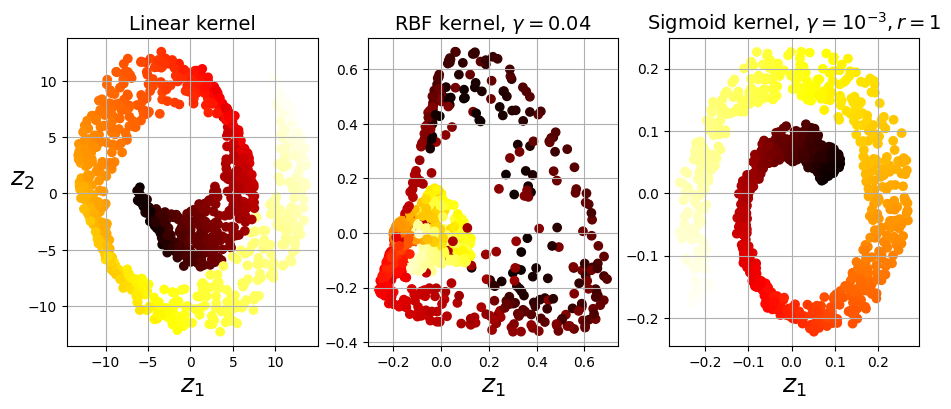

In [31]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)

    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### LLE - Locally Linear Embedding

Cria uma representação sem projeção mas sim tentando preservar a distância com os vizinhos mais próximos.

In [32]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [33]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

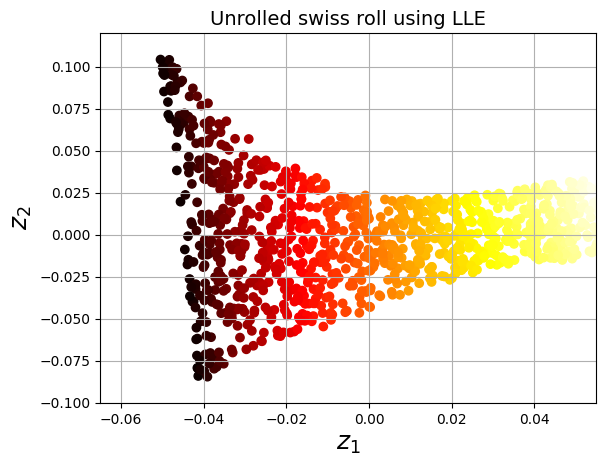

In [34]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

Parece funcionar bem